In [4]:
from stringprep import b1_set

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
with open('data/names.txt', 'r') as f:
    words = f.read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Кодировки

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

Создание датасета

In [7]:
block_size = 3 # context length

def build_dataset(words):
    # build the dataset
    X, Y = [], []
    for w in words:
        # print(w)
        # Лист болванка из 0 для дальнейшего заполнения
        context = [0] * block_size
        # print(context)
        for ch in w + '.':
            # Индекс символа в словаре
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            # Убрали первый символ, добавили новый
            context = context[1:] + [ix] # crop and append
            # print(context)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [8]:
import random

# Начало случайного распределения зафиксировано, дальше все что будет генерироваться при перезапуске программы будет одинаковым. Если вызывать несколько раз внутри одной и той же программы, результаты будут разными
random.seed(42)

Если seed не задавать, Python использует текущее время или системный источник энтропии

In [9]:
print(random.random())
print(random.random())
print(random.random())

0.6394267984578837
0.025010755222666936
0.27502931836911926


In [11]:
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182570, 3]) torch.Size([182570])
torch.Size([22668, 3]) torch.Size([22668])
torch.Size([22908, 3]) torch.Size([22908])


In [12]:
print(len(words))
print(n1)
print(n2)

32033
25626
28829


Определение MLP

In [13]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


Оптимизационный код

In [14]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activations
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 25.3636
  10000/ 200000: 2.5778
  20000/ 200000: 2.0606
  30000/ 200000: 2.4627
  40000/ 200000: 2.4529
  50000/ 200000: 2.4948
  60000/ 200000: 2.2895
  70000/ 200000: 2.0816
  80000/ 200000: 2.4105
  90000/ 200000: 2.6047
 100000/ 200000: 2.2398
 110000/ 200000: 1.8785
 120000/ 200000: 2.1691
 130000/ 200000: 2.4880
 140000/ 200000: 1.9370
 150000/ 200000: 2.2358
 160000/ 200000: 1.9472
 170000/ 200000: 1.8916
 180000/ 200000: 1.6782
 190000/ 200000: 2.1456


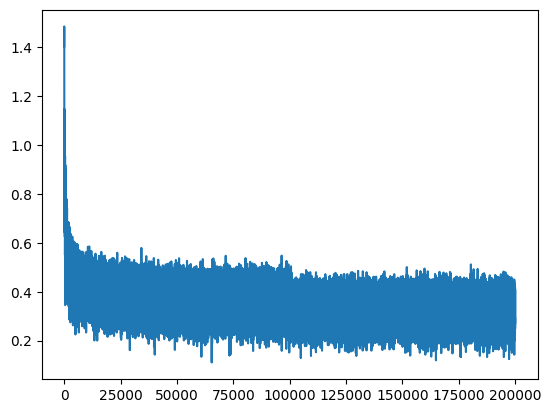

In [15]:
plt.plot(lossi)

In [16]:
# Что бы ни происходило в этой функции, никогда не нужны и не будут применены градиенты
# Все работает быстрее, можно делать через with torch.no_grad...
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Ytr),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1316959857940674
val 2.1766879558563232


In [17]:
g = torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0] * block_size # старт с ...
    while True:
        # Контекст на вход, в начале ..., далее заполняется сгенерированными буквами
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        # exps logits
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

anuella.
tis.
marian.
dante.
namillaylen.
kemarce.
man.
emiah.
aden.
dazi.
kenda.
jordin.
kalla.
mikolynn.
ace.
hine.
chanavitharlen.
jayma.
jaconnelari.
kalah.


### Изменяем веса при инициализации

На входе шансы встретить любую букву считаем равными

In [18]:
# Веса
print(torch.tensor(1/27.0))
# Ожидаемая ошибка, тк при случайной инициализации модель случайно сильно уверена в каких-то символах, и отсюда там вылазит сильно бОльшая ошибка
print(-torch.tensor(1/27.0).log())

tensor(0.0370)
tensor(3.2958)


### Тест 1, база

Проводим серию тестов, постепенно изменяя веса при инициализации, смотрим ошибку после первого прогона

In [19]:
def display_model_init_quality(h, hpreact):
    # Сделай одномерным массивом
    plt.hist(h.view(-1).tolist(), 50)
    plt.title('Model Activations')
    plt.show()
    plt.hist(hpreact.view(-1).tolist(), 50)
    plt.title('Model Pre-Activations')
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')
    plt.title('Almost dead neurons')


In [20]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [21]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break


      0/ 200000: 25.3636


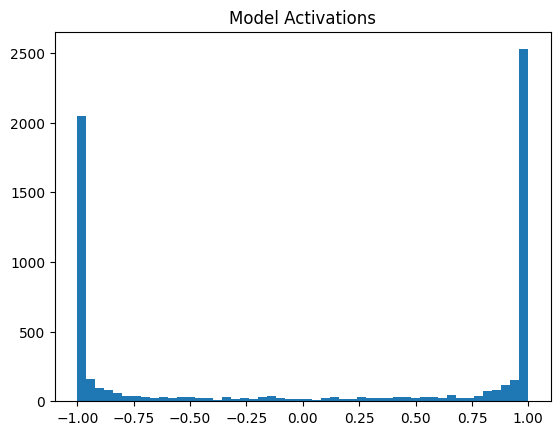

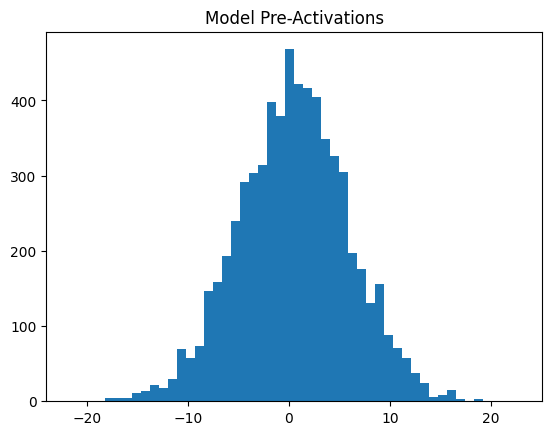

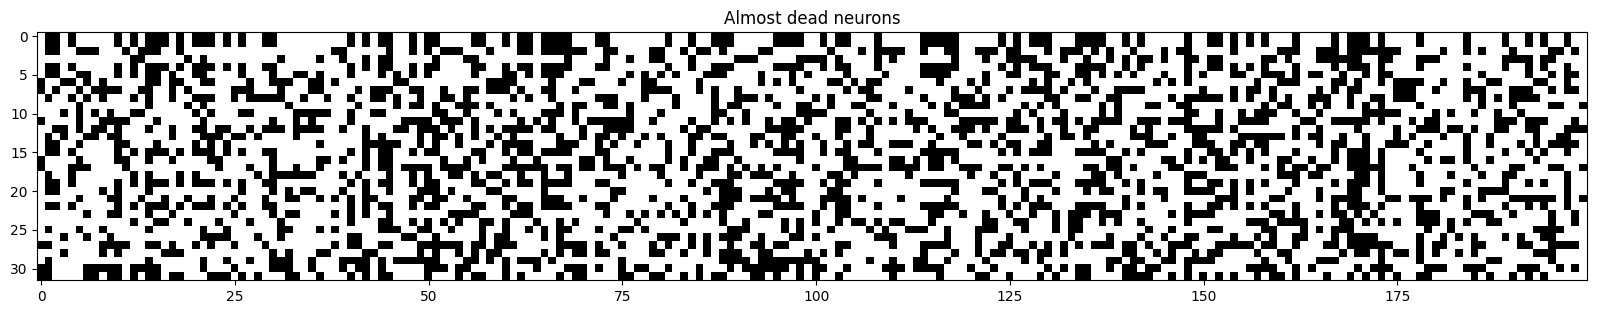

In [22]:
display_model_init_quality(h, hpreact)

In [23]:
logits[0]

tensor([ 12.4119,  -7.6996,   2.3776,   6.5568,  -6.7900, -15.6000, -21.2102,
         -0.6893,  13.2828, -12.5420,  -4.2807,  25.9170,   1.7245, -19.7246,
          2.6588,   7.7760, -15.6614,  14.8147,  16.6351,  -9.3979,  -6.0412,
         -2.7174,  -1.9348,  -4.2945,  -9.4654,  -5.1644,   0.7409],
       grad_fn=<SelectBackward0>)

### Тест 2, зануляю b2, уменьшаю W2, чтобы уменьшить значения первых околослучайных logits

In [24]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


      0/ 200000: 3.3045


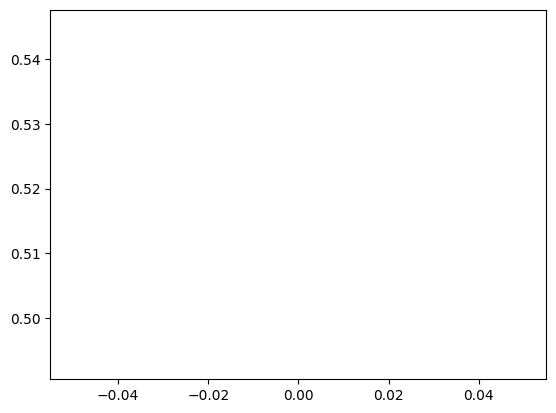

In [25]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
plt.plot(lossi)

In [26]:
h.shape

torch.Size([32, 200])

In [27]:
h

tensor([[-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-0.9993, -0.0673,  0.9300,  ...,  1.0000, -0.8518, -1.0000],
        ...,
        [-1.0000,  0.1622, -1.0000,  ...,  0.9986,  1.0000,  0.9995],
        [ 0.9412, -0.9763,  1.0000,  ..., -0.9986,  0.9842,  1.0000],
        [-0.9092,  0.9366, -1.0000,  ..., -1.0000,  0.9980,  1.0000]],
       grad_fn=<TanhBackward0>)

Смотрим распределение весов

In [2]:
# примеры идут подряд
# h.storage()

(array([2050.,  159.,   94.,   78.,   60.,   35.,   39.,   30.,   24.,
          28.,   22.,   29.,   29.,   22.,   21.,   11.,   32.,   18.,
          24.,   17.,   34.,   39.,   27.,   13.,   13.,   13.,   12.,
          20.,   28.,   13.,   15.,   28.,   23.,   21.,   24.,   28.,
          29.,   24.,   31.,   28.,   24.,   47.,   25.,   27.,   40.,
          76.,   79.,  115.,  156., 2526.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

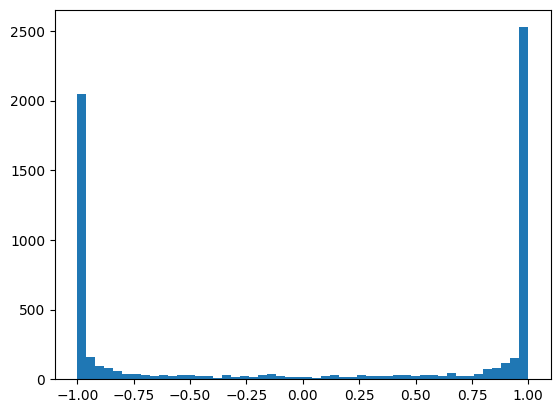

In [29]:
# Сделай одномерным массивом
plt.hist(h.view(-1).tolist(), 50)

tanh все зажаж в диапазон -1 1, и почти все веса близки к этому. Такой график это плохо, тк большая часть весов почти не меняется и не рабочая, мы находимся оч далеко на графике tanh, и почти всеми весами застряли в области малых градиентов

(array([  1.,   0.,   0.,   1.,   5.,   4.,   5.,  11.,  14.,  21.,  17.,
         29.,  69.,  58.,  73., 146., 158., 193., 240., 292., 303., 314.,
        398., 379., 468., 422., 416., 404., 349., 326., 305., 197., 176.,
        131., 156.,  88.,  71.,  58.,  38.,  24.,   6.,   9.,  15.,   3.,
          1.,   3.,   1.,   0.,   1.,   1.]),
 array([-21.82064819, -20.9272599 , -20.03387161, -19.14048332,
        -18.24709503, -17.35370674, -16.46031845, -15.56693016,
        -14.67354187, -13.78015358, -12.88676529, -11.993377  ,
        -11.09998871, -10.20660042,  -9.31321213,  -8.41982384,
         -7.52643555,  -6.63304726,  -5.73965897,  -4.84627068,
         -3.95288239,  -3.05949409,  -2.1661058 ,  -1.27271751,
         -0.37932922,   0.51405907,   1.40744736,   2.30083565,
          3.19422394,   4.08761223,   4.98100052,   5.87438881,
          6.7677771 ,   7.66116539,   8.55455368,   9.44794197,
         10.34133026,  11.23471855,  12.12810684,  13.02149513,
         13.914883

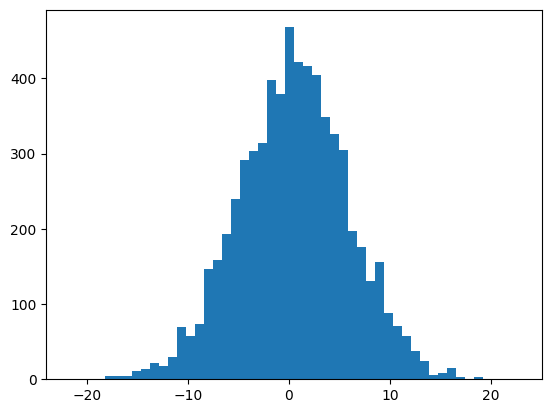

In [30]:
plt.hist(hpreact.view(-1).tolist(), 50)

На вход в tanh шли нормально распределеныые, но большие веса, почему они и стали -1 или 1

Визуализация как посмотреть на кол-во весов ушедших за 0.99

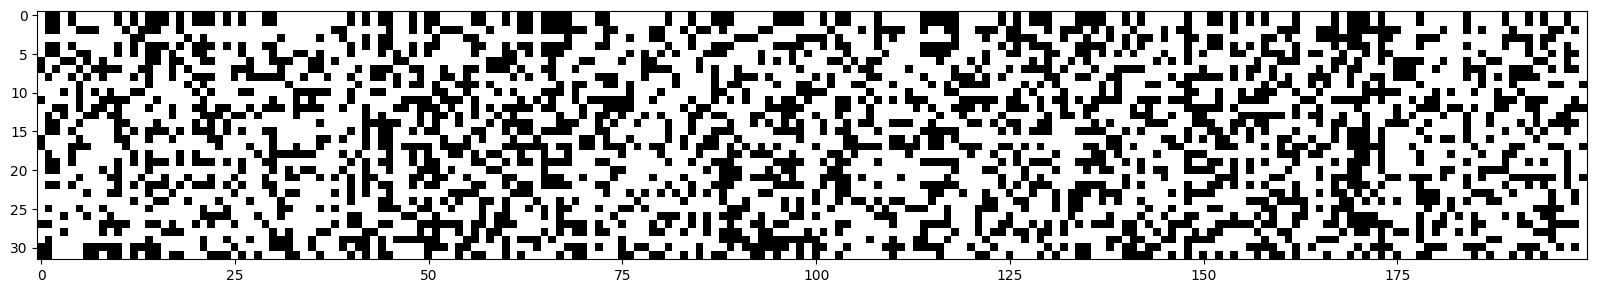

In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

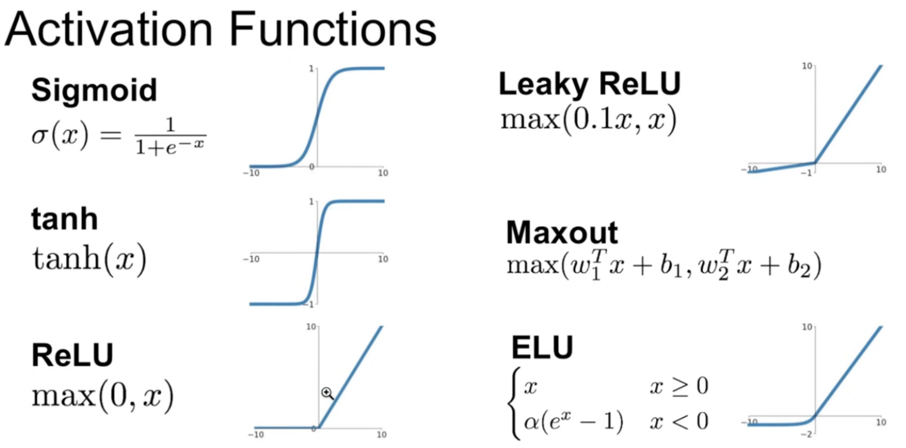

### Тест 3, уменьшаем W1 b1, чтобы убрать показанную проблему на этапе функции активации

In [32]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.01
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


      0/ 200000: 3.2961


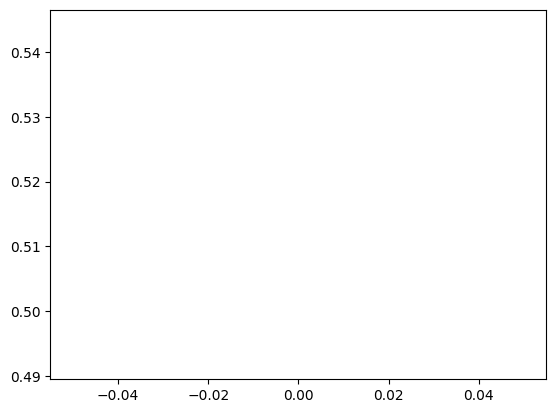

In [33]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
plt.plot(lossi)

In [34]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


      0/ 200000: 3.3037


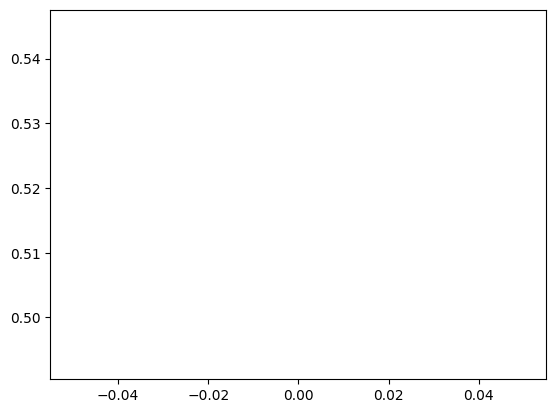

In [35]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
plt.plot(lossi)

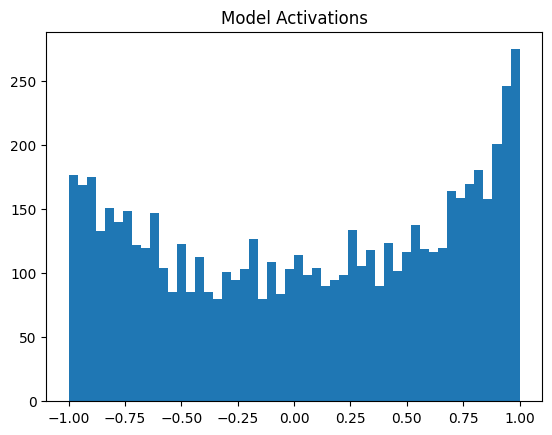

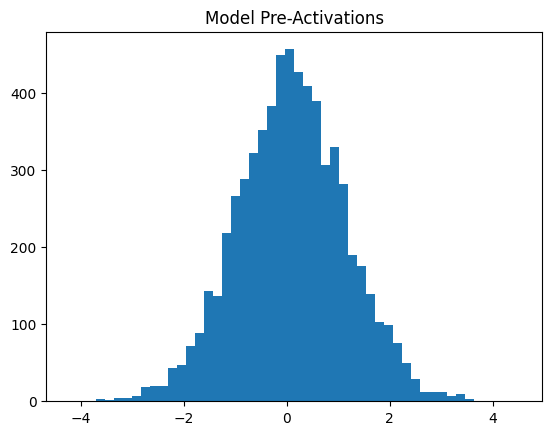

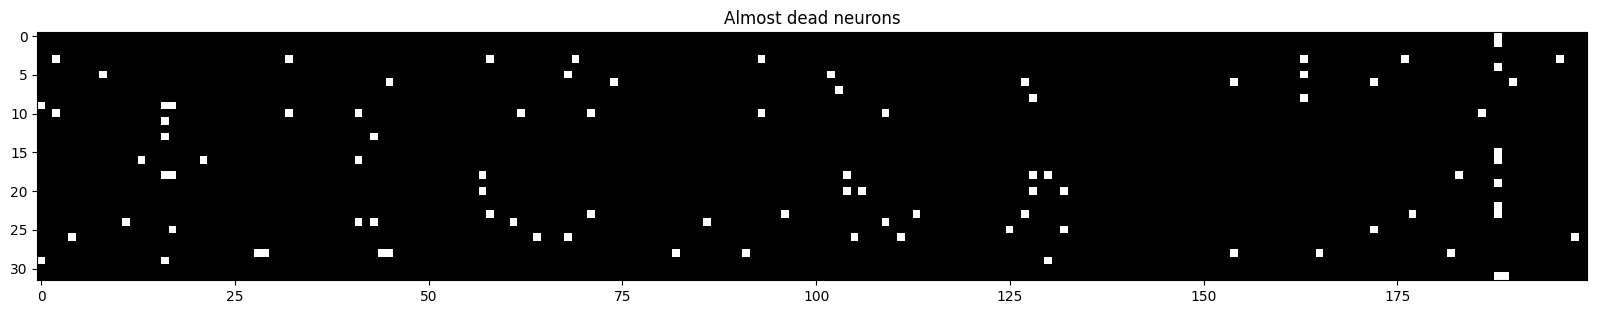

In [36]:
display_model_init_quality(h, hpreact)

Видно что ситуация улучшилась

      0/ 200000: 3.3040
  10000/ 200000: 2.3210
  20000/ 200000: 2.0805
  30000/ 200000: 2.3041
  40000/ 200000: 2.1725
  50000/ 200000: 1.9248
  60000/ 200000: 2.0697
  70000/ 200000: 2.0917
  80000/ 200000: 2.0753
  90000/ 200000: 2.0552
 100000/ 200000: 2.1232
 110000/ 200000: 1.7686
 120000/ 200000: 2.1356
 130000/ 200000: 2.0009
 140000/ 200000: 2.5471
 150000/ 200000: 2.1727
 160000/ 200000: 2.4127
 170000/ 200000: 2.0417
 180000/ 200000: 2.1731
 190000/ 200000: 1.9365


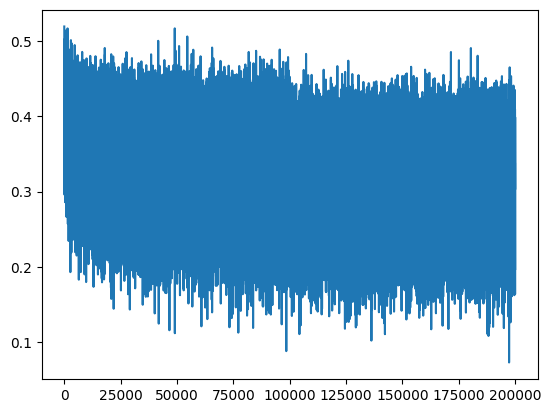

In [37]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
plt.plot(lossi)

In [38]:
split_loss('train')
split_loss('val')

train 2.035649538040161
val 2.105647087097168


В случае с такой сеткой даже при отвратительной инициализации она +- чему-то научится, но это не будет работать для более сложных и глубокий сетей 100%

tensor(0.0111) tensor(0.9938)
tensor(0.0038) tensor(3.1902)


(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00,
        1.2000e+01, 7.0000e+00, 1.6000e+01, 4.2000e+01, 6.9000e+01,
        9.0000e+01, 1.7100e+02, 2.4200e+02, 4.2600e+02, 6.7900e+02,
        1.0500e+03, 1.7250e+03, 2.5050e+03, 3.7390e+03, 5.6590e+03,
        7.9250e+03, 1.0752e+04, 1.3942e+04, 1.7004e+04, 1.9588e+04,
        2.0361e+04, 2.0072e+04, 1.8273e+04, 1.5097e+04, 1.2047e+04,
        9.0280e+03, 6.3360e+03, 4.5540e+03, 3.1190e+03, 2.0800e+03,
        1.2570e+03, 8.2700e+02, 5.4900e+02, 2.9300e+02, 1.9100e+02,
        9.8000e+01, 7.4000e+01, 3.1000e+01, 2.1000e+01, 2.2000e+01,
        1.3000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-19.41962624, -18.66408123, -17.90853622, -17.15299122,
        -16.39744621, -15.64190121, -14.8863562 , -14.1308112 ,
        -13.37526619, -12.61972118, -11.86417618, -11.10863117,
        -10.35308617,  -9.59754116,  -8.84199615,  -8.08645115,
         -7.33090614,  -6.57536114,  -5.81981613,  -5.06427113

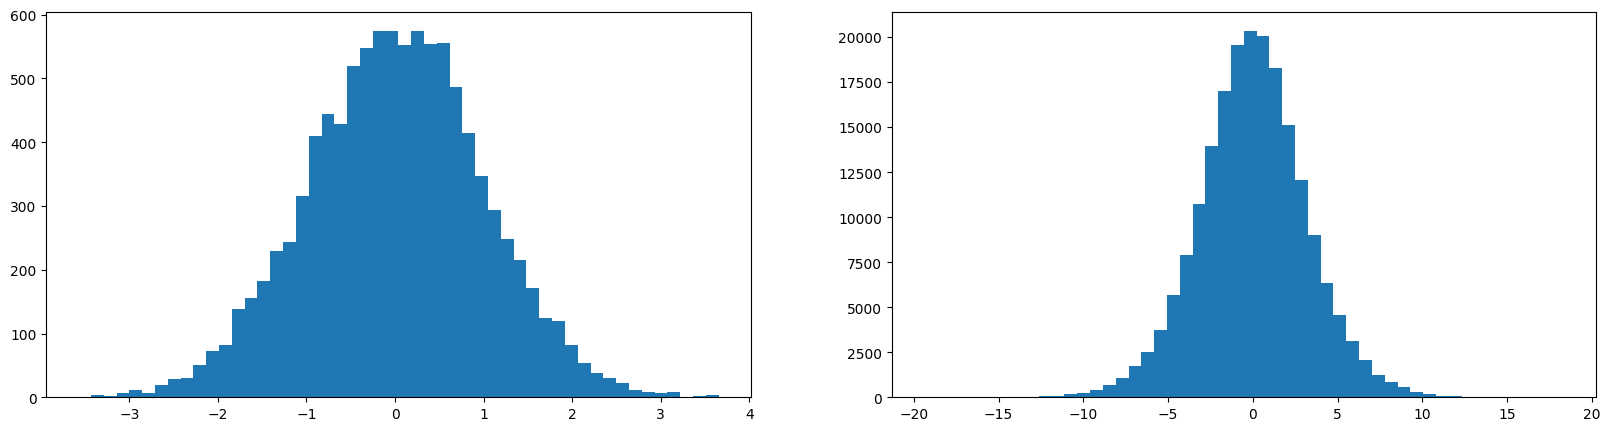

In [39]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50)

Инициализировали W и X, при перемножении среднее итога осталось средним, STD выросло в 3 раза

tensor(-0.0032) tensor(1.0051)
tensor(0.0015) tensor(0.6287)


(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+01, 1.7000e+01, 2.9000e+01, 4.8000e+01,
        8.5000e+01, 1.2100e+02, 2.2900e+02, 3.4700e+02, 6.2000e+02,
        1.0400e+03, 1.5460e+03, 2.4900e+03, 3.5770e+03, 5.2650e+03,
        7.4980e+03, 9.9100e+03, 1.2926e+04, 1.5817e+04, 1.8359e+04,
        1.9760e+04, 1.9666e+04, 1.8175e+04, 1.6049e+04, 1.3069e+04,
        1.0183e+04, 7.5850e+03, 5.2750e+03, 3.6490e+03, 2.4830e+03,
        1.5890e+03, 9.9800e+02, 6.5100e+02, 3.6700e+02, 2.2400e+02,
        1.5100e+02, 7.5000e+01, 5.0000e+01, 3.0000e+01, 1.3000e+01,
        8.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-3.80043244e+00, -3.65431451e+00, -3.50819658e+00, -3.36207865e+00,
        -3.21596072e+00, -3.06984279e+00, -2.92372486e+00, -2.77760693e+00,
        -2.63148900e+00, -2.48537107e+00, -2.33925314e+00, -2.19313521e+00,
        -2.04701728e+00, -1.90089935e+00, -1.75478142e+00, -1.60866349e+00,
        -1.462

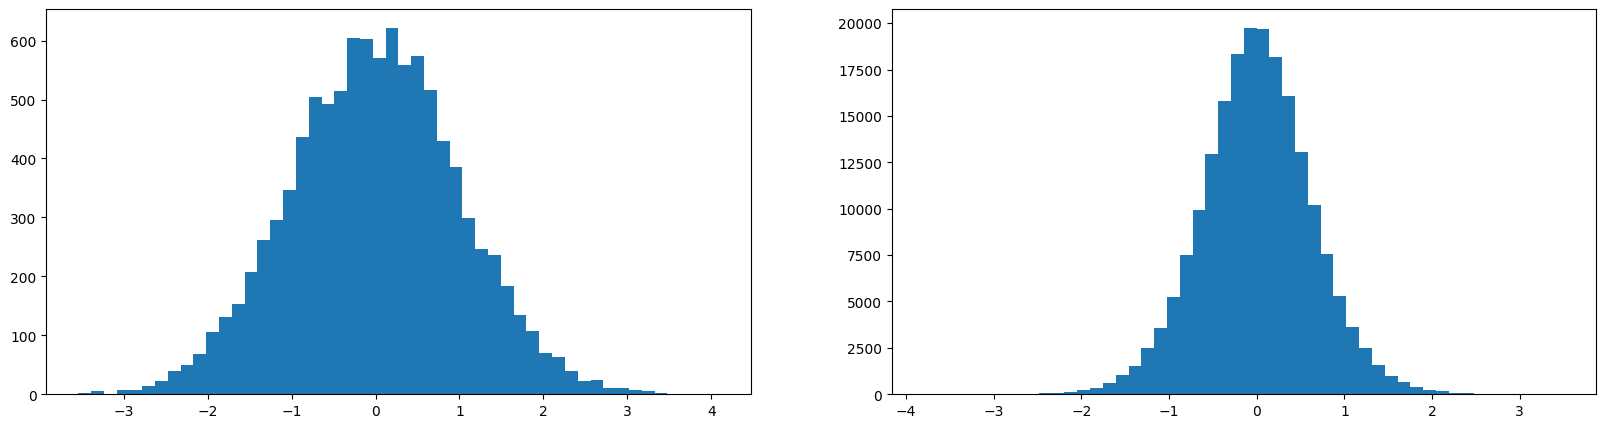

In [40]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50)

При инициализации весов нужно уеньших их так, чтобы после произведения было нормальное стандартное отклонение.

tensor(0.0111) tensor(0.9971)
tensor(0.0003) tensor(0.9956)


(array([1.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 9.0000e+00,
        7.0000e+00, 2.3000e+01, 3.9000e+01, 6.0000e+01, 9.5000e+01,
        1.1700e+02, 2.0200e+02, 3.6100e+02, 6.0500e+02, 9.4900e+02,
        1.3820e+03, 2.0170e+03, 3.0260e+03, 4.3150e+03, 6.1660e+03,
        8.3560e+03, 1.0954e+04, 1.3654e+04, 1.6251e+04, 1.7912e+04,
        1.8790e+04, 1.8232e+04, 1.7127e+04, 1.4872e+04, 1.2147e+04,
        9.4650e+03, 7.0640e+03, 5.1910e+03, 3.5810e+03, 2.4960e+03,
        1.6530e+03, 1.0480e+03, 6.9700e+02, 4.3600e+02, 2.7200e+02,
        1.6500e+02, 1.0800e+02, 6.7000e+01, 3.2000e+01, 2.1000e+01,
        1.3000e+01, 9.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-5.64069366, -5.42136817, -5.20204268, -4.98271718, -4.76339169,
        -4.54406619, -4.3247407 , -4.1054152 , -3.88608971, -3.66676421,
        -3.44743872, -3.22811322, -3.00878773, -2.78946223, -2.57013674,
        -2.35081124, -2.13148575, -1.91216025, -1.69283476, -1.47350926,
        -1.25418377, -1.03

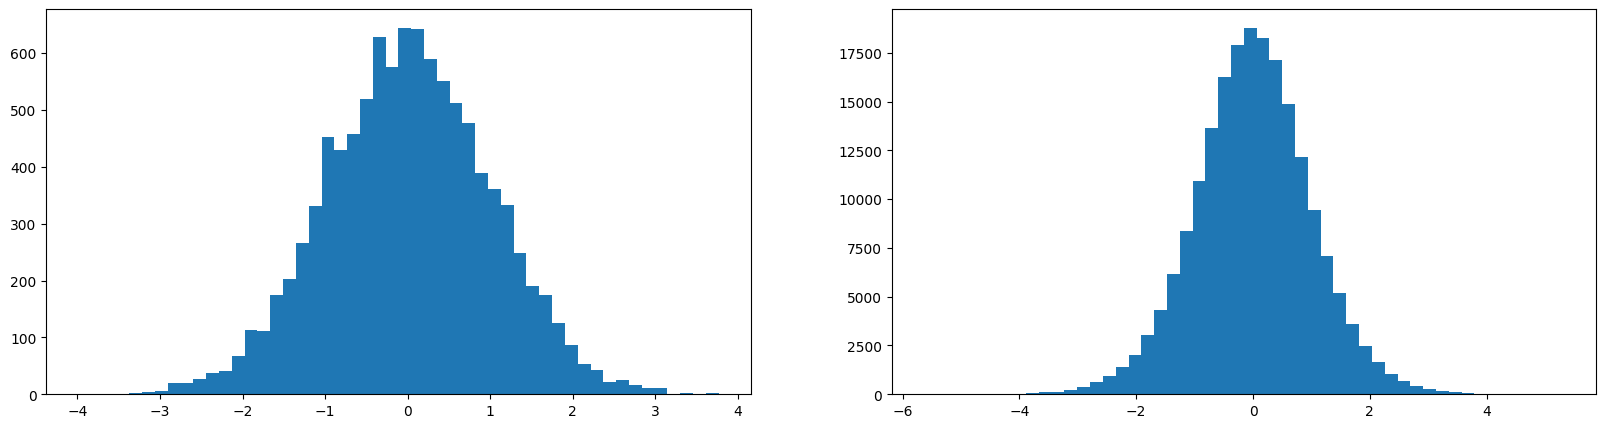

In [41]:
x = torch.randn(1000, 10)
# Математический правильный делитель чтобы оставить STD произведения в нужном диапазоне
w = torch.randn(10, 200) / 10**0.5

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50)

Инициализация весов через torch

In [42]:
_ = torch.nn.init.kaiming_normal_(torch.empty((100, 200), dtype=torch.float),
                                  mode='fan_in',
                                  nonlinearity='tanh')

(array([1.000e+00, 4.000e+00, 1.000e+00, 5.000e+00, 6.000e+00, 1.000e+01,
        1.800e+01, 2.900e+01, 5.400e+01, 8.300e+01, 9.600e+01, 1.420e+02,
        1.930e+02, 2.660e+02, 3.330e+02, 4.070e+02, 5.140e+02, 6.150e+02,
        7.480e+02, 8.660e+02, 9.840e+02, 1.029e+03, 1.186e+03, 1.181e+03,
        1.284e+03, 1.244e+03, 1.211e+03, 1.221e+03, 1.109e+03, 9.680e+02,
        8.410e+02, 6.930e+02, 6.350e+02, 4.750e+02, 3.950e+02, 3.490e+02,
        2.590e+02, 1.630e+02, 1.290e+02, 7.300e+01, 5.400e+01, 4.800e+01,
        2.500e+01, 1.900e+01, 1.200e+01, 7.000e+00, 1.000e+01, 2.000e+00,
        2.000e+00, 1.000e+00]),
 array([-0.46022764, -0.44172967, -0.4232317 , -0.40473373, -0.38623576,
        -0.36773779, -0.34923982, -0.33074185, -0.31224388, -0.29374591,
        -0.27524794, -0.25674997, -0.238252  , -0.21975403, -0.20125607,
        -0.1827581 , -0.16426013, -0.14576216, -0.12726419, -0.10876622,
        -0.09026825, -0.07177028, -0.05327231, -0.03477434, -0.01627637,
         0.

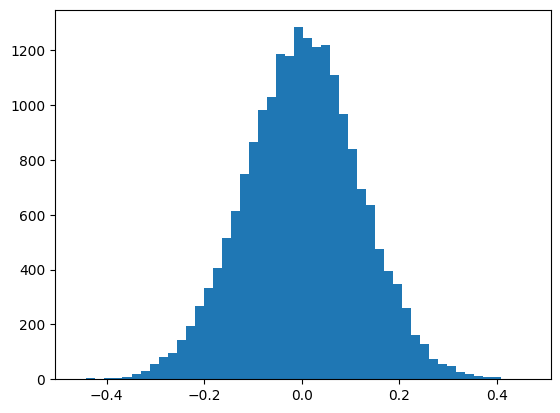

In [43]:
plt.hist(_.view(-1).tolist(), bins=50)

In [44]:
torch.randn(10000).std()

tensor(1.0021)

In [45]:
torch.randn(10000).std() * 0.2

tensor(0.2015)

In [46]:
# gain для tanh 5/3, вход 30
(5 / 3) / (30 **0.5)

0.3042903097250923

In [47]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


      0/ 200000: 3.3058
  10000/ 200000: 2.2233
  20000/ 200000: 2.0154
  30000/ 200000: 2.1621
  40000/ 200000: 2.0870
  50000/ 200000: 2.1365
  60000/ 200000: 1.9862
  70000/ 200000: 2.0690
  80000/ 200000: 2.3355
  90000/ 200000: 2.4270
 100000/ 200000: 1.9816
 110000/ 200000: 1.7904
 120000/ 200000: 2.0591
 130000/ 200000: 2.2953
 140000/ 200000: 1.7582
 150000/ 200000: 1.9688
 160000/ 200000: 1.7966
 170000/ 200000: 1.8803
 180000/ 200000: 1.6804
 190000/ 200000: 2.1836


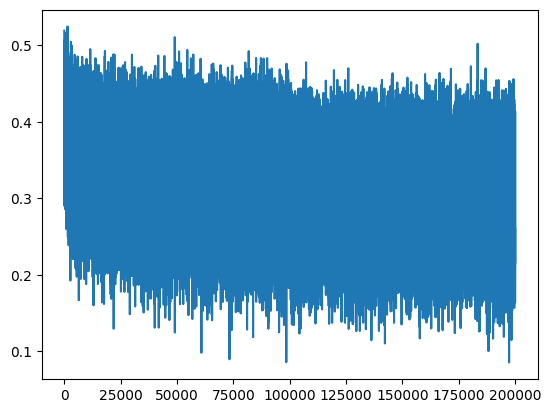

In [48]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  # break
plt.plot(lossi)

In [49]:
split_loss('train')
split_loss('val')

train 2.0353357791900635
val 2.1057934761047363


# BatchNorm

In [50]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [51]:
# 200 колонок - 200 нейронов

hpreact

tensor([[-2.3423, -0.9169,  0.2829,  ..., -0.5286, -3.2816,  1.8116],
        [-3.4734,  0.6989, -3.7892,  ...,  1.9184, -3.5973,  4.2713],
        [ 0.6515,  2.5613,  2.0009,  ...,  3.9769, -0.9652,  1.6980],
        ...,
        [ 2.3241,  3.7516, -1.5839,  ..., -2.5440, -0.8266,  2.8113],
        [-0.1103,  1.0852, -1.0351,  ..., -0.7996,  1.4676,  1.1643],
        [-0.2778, -1.6861, -0.7255,  ..., -6.0433,  2.7076, -0.2348]],
       grad_fn=<AddBackward0>)

In [52]:
hpreact.shape

torch.Size([32, 200])

In [53]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [54]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [55]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


      0/ 200000: 3.3065
  10000/ 200000: 2.3215
  20000/ 200000: 2.0957
  30000/ 200000: 2.1403
  40000/ 200000: 2.2473
  50000/ 200000: 2.2354
  60000/ 200000: 2.1409
  70000/ 200000: 2.0911
  80000/ 200000: 2.2552
  90000/ 200000: 2.3679
 100000/ 200000: 1.7994
 110000/ 200000: 1.8597
 120000/ 200000: 2.1080
 130000/ 200000: 2.3450
 140000/ 200000: 1.7899
 150000/ 200000: 2.0386
 160000/ 200000: 1.9375
 170000/ 200000: 1.9142
 180000/ 200000: 1.7267
 190000/ 200000: 2.2517


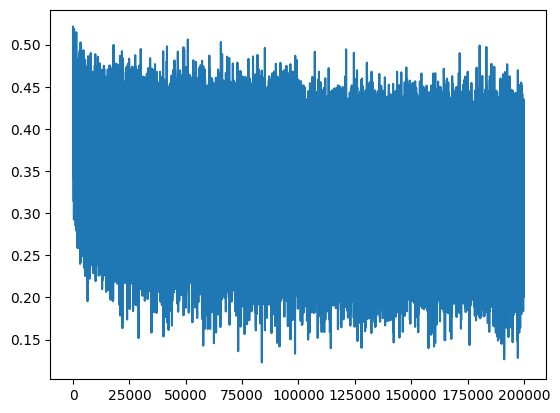

In [56]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations


    # BatchNorm
    # Стандартизация и нормализация
    hpreact = hpreact - hpreact.mean(0, keepdim=True)
    hpreact = hpreact / hpreact.std(0, keepdim=True)

    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias



    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  # break
plt.plot(lossi)

In [57]:
# Добавил BatchNorm к верификации
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Ytr),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

        # BatchNorm
    # Стандартизация и нормализация
    hpreact = hpreact - hpreact.mean(0, keepdim=True)
    hpreact = hpreact / hpreact.std(0, keepdim=True)

    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0677878856658936
val 2.108212947845459


Для семплирования из сетки с применением BatchNorm недобходимо зафиксировать единые средние значения bnmean и bnstd, и затем применять их в ходе семплирования

In [58]:
with torch.no_grad():
    # Берем весь training set, получаем эмбеддинги для него
    emb = C[Xtr]
    # Разворачиваем в 2д матрицу
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [59]:
C.shape

torch.Size([27, 10])

In [60]:
Xtr.shape

torch.Size([182570, 3])

In [61]:
C[Xtr].shape

torch.Size([182570, 3, 10])

Что делает C[Xtr]

PyTorch интерпретирует Xtr как набор индексов по первой оси C.

То есть:

Каждый элемент Xtr[i, j] используется как индекс строки в C

Типичный сценарий использования

Чаще всего это используется как embedding lookup:

	•	C — embedding-матрица
	•	Xtr — последовательности токенов / символов
	•	C[Xtr] — embedding-представление входных данных

In [62]:
emb.view(emb.shape[0], -1)

tensor([[ 1.1572,  0.3243,  0.1734,  ..., -0.0023, -0.3184,  0.3468],
        [ 1.1572,  0.3243,  0.1734,  ...,  0.9743, -0.6385, -1.5867],
        [ 1.1572,  0.3243,  0.1734,  ..., -0.4903,  0.7461, -0.0239],
        ...,
        [-0.1710,  1.0114, -0.0681,  ..., -0.7341,  0.1464, -0.8468],
        [ 0.3322, -0.8352, -1.0291,  ...,  0.2758,  0.6976, -1.8186],
        [-0.1710,  1.0114, -0.0681,  ..., -1.3455, -1.7331, -1.0885]])

In [63]:
# Добавил BatchNorm к верификации
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Ytr),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

    # BatchNorm
    # Стандартизация и нормализация, с использованием средних значений по всему training set
    hpreact = hpreact - bnmean
    hpreact = hpreact / bnstd
    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0677878856658936
val 2.1083314418792725


Вместо оценки mean и std в конце обычно в циклы обучения просто добавляется скользящая оценка по ходу дела

In [64]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Контроль смещения и разброса статистики BN слоя
bngain = torch.ones((1, n_hidden)) # scale
bnbias = torch.zeros((1, n_hidden)) # shift

# Не оптимизируются в процессе обучения, просто обновляются как переменные
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


      0/ 200000: 3.3065
  10000/ 200000: 2.3215
  20000/ 200000: 2.0957
  30000/ 200000: 2.1403
  40000/ 200000: 2.2473
  50000/ 200000: 2.2354
  60000/ 200000: 2.1409
  70000/ 200000: 2.0911
  80000/ 200000: 2.2552
  90000/ 200000: 2.3679
 100000/ 200000: 1.7994
 110000/ 200000: 1.8597
 120000/ 200000: 2.1080
 130000/ 200000: 2.3450
 140000/ 200000: 1.7899
 150000/ 200000: 2.0386
 160000/ 200000: 1.9375
 170000/ 200000: 1.9142
 180000/ 200000: 1.7267
 190000/ 200000: 2.2517


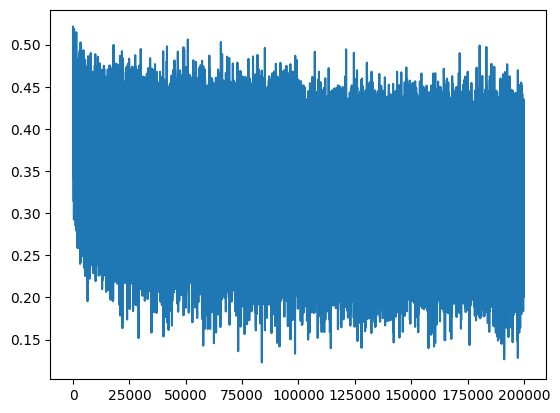

In [65]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations


    # BatchNorm
    # Стандартизация и нормализация

    # Оценка среднего и стд по ходу дела
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = hpreact - hpreact.mean(0, keepdim=True)
    hpreact = hpreact / hpreact.std(0, keepdim=True)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd




    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias



    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  # break
plt.plot(lossi)

In [66]:
with torch.no_grad():
    # Берем весь training set, получаем эмбеддинги для него
    emb = C[Xtr]
    # Разворачиваем в 2д матрицу
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

Видно, что оценки если посчитать статистику отдельно, и скользящим окном близки, поэтому можно использовать скользящее окно, в BN pytorch так и сделано

In [67]:
print(bnmean)

tensor([[-2.1580,  0.6479, -1.0067,  0.8812,  0.6645,  1.1356,  2.6082, -2.1723,
          0.9236,  1.0973, -1.6970, -2.6179, -0.2099, -0.1833,  0.3107,  0.2315,
          0.5466, -3.0315, -1.0637,  0.8032, -0.7544,  0.1613, -0.5935,  0.3172,
          1.4169,  1.3623,  1.2576, -0.3517,  1.1298,  1.3525, -0.5403, -1.2804,
          0.3408,  0.0651, -0.9249, -1.4654,  0.0417, -0.0300, -0.2776,  0.3625,
         -0.3066, -1.6821, -0.2004,  0.0865,  0.6497, -0.4826,  1.9372, -1.3304,
          2.5928,  1.1924,  1.2440,  0.0374,  2.0286,  1.2406,  1.0491, -2.8229,
         -0.4457,  0.4038,  1.6601, -1.7407, -1.3611,  1.1488,  0.0058,  0.3702,
          1.5199,  1.1742,  0.0887,  1.7033, -0.9535, -0.1650,  0.1737,  0.6569,
          0.7780, -1.4484, -2.3963,  0.6214,  1.4147, -1.0440,  0.8510,  0.4487,
          0.6089,  1.4772,  1.5964, -0.2184, -0.2879, -0.6018, -0.5736,  0.2264,
          2.4421, -0.3679, -1.2975,  0.6855, -1.4328, -1.6087, -0.8314,  0.8456,
          0.3859, -0.6675, -

In [68]:
print(bnmean_running)

tensor([[-2.1731,  0.6354, -0.9968,  0.8598,  0.6621,  1.1488,  2.6038, -2.1604,
          0.9062,  1.0870, -1.6978, -2.6024, -0.2110, -0.1937,  0.2988,  0.2082,
          0.5342, -3.0317, -1.0575,  0.8034, -0.7465,  0.1435, -0.5967,  0.3144,
          1.4304,  1.3421,  1.2414, -0.3590,  1.1354,  1.3397, -0.5515, -1.2723,
          0.3263,  0.0576, -0.9326, -1.4571,  0.0444, -0.0304, -0.2828,  0.3447,
         -0.3078, -1.6988, -0.2080,  0.0708,  0.6503, -0.4707,  1.9220, -1.3329,
          2.5958,  1.1948,  1.2462,  0.0450,  2.0253,  1.2234,  1.0471, -2.8046,
         -0.4498,  0.4429,  1.6632, -1.7289, -1.3574,  1.1470,  0.0035,  0.3662,
          1.5194,  1.1648,  0.0907,  1.6972, -0.9518, -0.1708,  0.1529,  0.6695,
          0.7734, -1.4409, -2.4143,  0.6270,  1.4129, -1.0527,  0.8284,  0.4522,
          0.5960,  1.4748,  1.5839, -0.2101, -0.3062, -0.5979, -0.5514,  0.2372,
          2.4445, -0.3645, -1.2861,  0.6758, -1.4234, -1.6188, -0.8414,  0.8272,
          0.3695, -0.6749, -

Оценка с использованием running оценки среднего и std

In [69]:
# Добавил BatchNorm к верификации
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Ytr),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

    # BatchNorm
    # Стандартизация и нормализация, с использованием средних значений по всему training set
    hpreact = hpreact - bnmeani
    # Для математической стабильности, чтобы избежать деления на 0 при std равном идеально 0
    epsilon = 1e-5
    hpreact = hpreact / (bnstdi + epsilon)
    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0846505165100098
val 2.12225604057312


Как видно, b почти равен нулю, тк мы при добавлении BN постоянно смещаем среднее к 0, а поэтому каждый раз избавляемся от эффекта смещения. Поэтому при использовании BN bias опускается. Теперь bias от BN отвечает за этот смысл

In [70]:
b1.grad.mean()

tensor(-1.3002e-10)

In [71]:
b1.grad.sum()

tensor(-2.6004e-08)

In [72]:
epsilon = 1e-5
epsilon

1e-05

### Переписанный чистовой вариант bn

In [77]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 ТК для этого слоя используется BN
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


# Параметры BatchNorm
bngain = torch.ones((1, n_hidden)) # scale
bnbias = torch.zeros((1, n_hidden)) # shift
# Не оптимизируются в процессе обучения, просто обновляются как переменные
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [78]:
max_stems = 200_000
batch_size = 256
lossi = []

for i in range(max_steps):
    # Индексы батча
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb] # Кодирую символы как эмбеддинги
    embcat = emb.view(emb.shape[0], -1) # Разворачиваю эмбеддинги в вектора

    # Linear Layer
    hpreact = embcat @ W1 # + b1 hidden layer pre-activation

    # BatchNorm layer
    # ------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnmeani
    # ------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    # torch.nn.functional.cross_entropy — это комбинация двух операций:
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    # Рассчитываем и записываем градиенты для параметров
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # Берется тензор с параметрами, и сразу обновляется весь, .data нужно для доступа к содержимому
    for p in parameters:
        p.data += - lr * p.grad

    if i % 10_000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2902
  10000/ 200000: 2.0788
  20000/ 200000: 2.0873
  30000/ 200000: 2.2414
  40000/ 200000: 2.1164
  50000/ 200000: 2.1290
  60000/ 200000: 2.1422
  70000/ 200000: 2.1155
  80000/ 200000: 1.9755
  90000/ 200000: 1.9484
 100000/ 200000: 1.9682
 110000/ 200000: 2.0323
 120000/ 200000: 2.0072
 130000/ 200000: 2.0818
 140000/ 200000: 2.0759
 150000/ 200000: 2.1323
 160000/ 200000: 2.0263
 170000/ 200000: 2.0303
 180000/ 200000: 2.1178
 190000/ 200000: 2.0955


In [79]:
print(p.grad)

tensor([[-7.0383e-03,  9.9370e-03, -2.5906e-03, -2.9037e-03, -1.4324e-04,
          1.1571e-03,  1.1513e-02, -1.7051e-02, -1.7679e-03, -4.2423e-03,
          7.4045e-03,  2.3615e-03, -2.1699e-03,  4.5422e-03,  6.5600e-03,
         -1.2631e-02,  1.0653e-02,  2.9248e-03, -6.2107e-03, -1.1809e-02,
          4.5142e-03, -9.7688e-04,  3.8189e-03, -2.8231e-03, -6.0412e-03,
         -5.5140e-03,  1.4784e-02, -4.1400e-03, -1.0417e-02, -6.1607e-03,
          8.9221e-03, -2.2999e-03, -1.4621e-02,  1.7041e-03, -2.6151e-05,
         -1.1151e-03, -2.4562e-03,  1.5293e-03,  1.0809e-04, -9.4992e-04,
         -2.8349e-03,  1.4095e-03,  9.4069e-04, -8.1294e-03,  1.0066e-02,
          4.4129e-03,  4.9941e-03,  1.6429e-02,  2.1724e-03,  6.5226e-03,
         -5.7539e-03, -2.5884e-03,  1.8212e-03,  2.1692e-03, -3.2672e-03,
         -1.2857e-02, -9.2795e-03, -8.1213e-04, -3.6829e-03, -1.5743e-03,
         -2.3535e-03, -9.3770e-03, -3.3009e-04,  3.8286e-04, -5.8490e-03,
         -1.6091e-02,  2.7928e-03,  8.

На примере ResNet было рассказано понятие BottleNeck block - Когда сетка состоит из пачки повторяющихся "типовых" блоков, напимер Conv + BN + Relu, и эта конструкция повторяется.

Мы тут примерно это и написали

### Продолжение после just kidding :)

Собираем и тренируем более глубокую сетку

In [133]:
# Аналог LinerLayer из pytorch, за исключением девайса на котором считать и dtype
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        """
        :param fan_in: кол-во инпутов
        :param fan_out: кол-во аутпутов
        :param bias: нужен ли bias
        """
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

# Тяжелый ли для рассчета это слой?
# Используетя ли сейчас он, или какие-то более современные аналоги?
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # Разделяем поведение на training mode и evaluation mode
        self.training = True

        # Параметры тренируемые в BatchNorm
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Обновляемые в ходе расчета скользящие значения параметров
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        # Во время тренировки используем среднее и отклонение из текущего батча
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.std(0, keepdim=True, unbiased=True) # batch var
        # Во время теста используем скользящие значения среднего и отклонения
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # BN трансформация
        self.out = self.gamma * xhat + self.beta

        # Обновление скользящих значений параметров (buffers), не тренируются
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [134]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) * 0.01
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # Уменьшаем уверенность поледнего слоя
    layers[-1].weights *= 0.1
    # Для всех остальных весов делаем балансировку (applying gain)
	# 1.	Инициализация весов с коэффициентом усиления
	# 2.	Масштабирование весов при инициализации
	# 3.	Корректировка масштаба весов (при инициализации)
	# 4.	Балансировка дисперсии весов

    # Без балансировки
    #     •	дисперсия активаций уменьшается слой за слоем
    #     •	градиенты затухают
    #     •	обучение медленное или нестабильное
    #
    # С балансировкой
    #     •	Var(activations) ≈ const
    #     •	Var(gradients) ≈ const
    #     •	сеть обучается быстрее и устойчивее
    #
    # Это идея Xavier / He initialization, но применённая вручную.

    for layer in layers:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

# Double list comprehansion
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


      0/ 200000: 3.2461


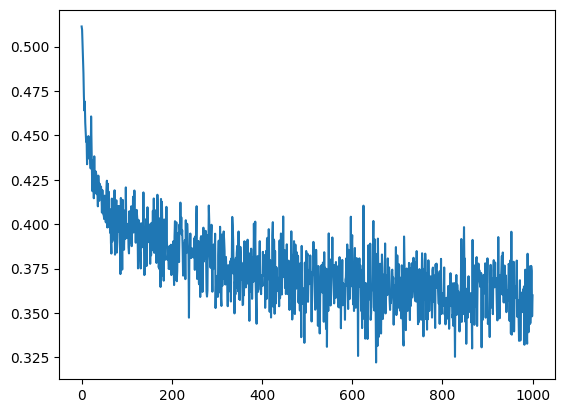

In [146]:
max_steps = 200_000
batch_size = 256
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Embedding
    emb = C[Xb] # embed characters into vectors
    # Оставь размерность 0, сделай вторую какой хочешь -> для каждого примера из 3 букв разверни их
    # в один уровень
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        # Вызывается метод __call__
        x = layer(x)

    # x — логиты (не softmax)
    # F.cross_entropy внутри применяет log_softmax и считает NLL loss
    loss = F.cross_entropy(x, Yb)
    # loss = F.nll_loss(F.log_softmax(x, dim=1), Yb)

    # Backward pass
    # for layer in layers:
    #     layer.out.retains_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update weights
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i == 1000:
        break

plt.plot(lossi)

layer 1 (      Tanh): mean -0.00, std 0.27, saturated: 0.00%
layer 3 (      Tanh): mean +0.01, std 0.40, saturated: 0.00%
layer 5 (      Tanh): mean -0.01, std 0.56, saturated: 0.97%
layer 7 (      Tanh): mean -0.04, std 0.66, saturated: 5.74%
layer 9 (      Tanh): mean +0.04, std 0.72, saturated: 11.04%


Text(0.5, 1.0, 'activation distribution')

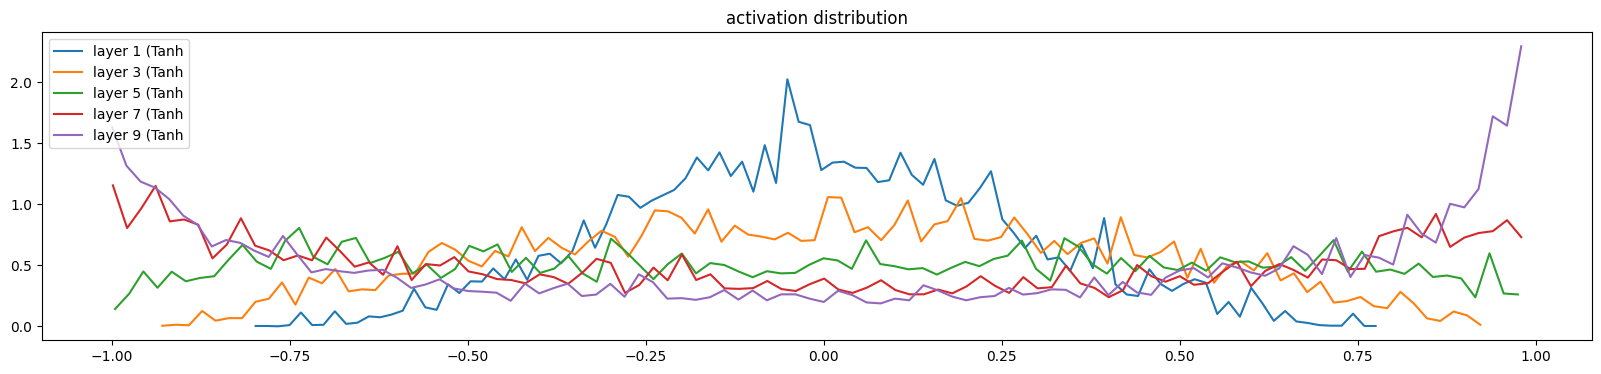

In [147]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [3]:
# # visualize histograms
# plt.figure(figsize=(20, 4)) # width and height of the plot
# legends = []
# for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
#   if isinstance(layer, Tanh):
#     t = layer.out.grad
#     print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
#     hy, hx = torch.histogram(t, density=True)
#     plt.plot(hx[:-1].detach(), hy.detach())
#     legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends);
# plt.title('gradient distribution')

weight   (27, 10) | mean -0.000544 | std 2.089878e-02 | grad:data ratio 1.595199e-01
weight  (30, 100) | mean +0.000058 | std 2.236982e-03 | grad:data ratio 7.135631e-03
weight (100, 100) | mean +0.000026 | std 2.050662e-03 | grad:data ratio 1.226800e-02
weight (100, 100) | mean +0.000003 | std 1.806042e-03 | grad:data ratio 1.068431e-02
weight (100, 100) | mean -0.000017 | std 1.711949e-03 | grad:data ratio 1.015513e-02
weight (100, 100) | mean -0.000006 | std 1.518590e-03 | grad:data ratio 8.977881e-03
weight  (100, 27) | mean +0.000000 | std 7.894267e-03 | grad:data ratio 1.168174e-01


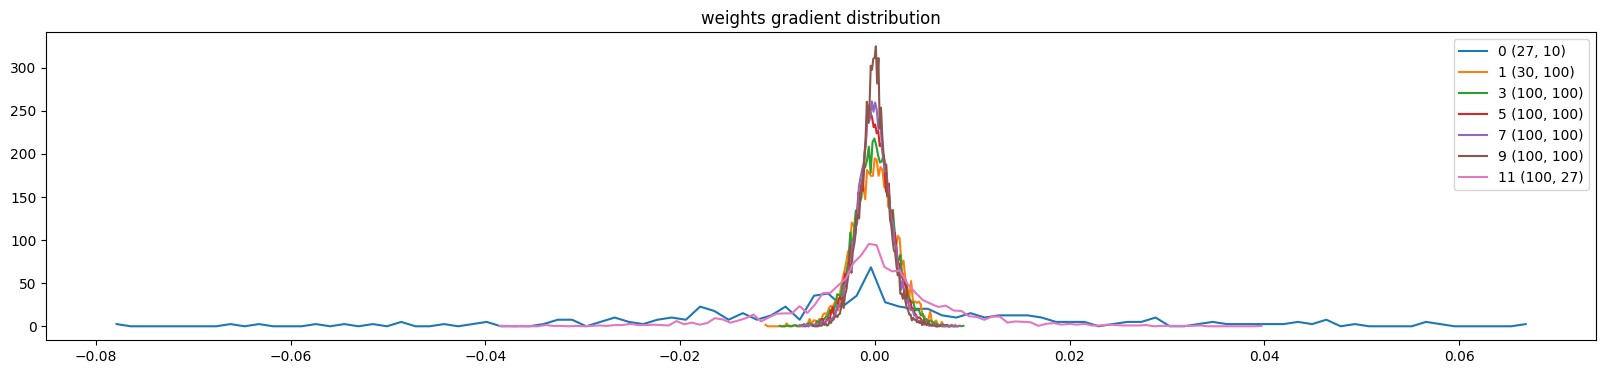

In [149]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

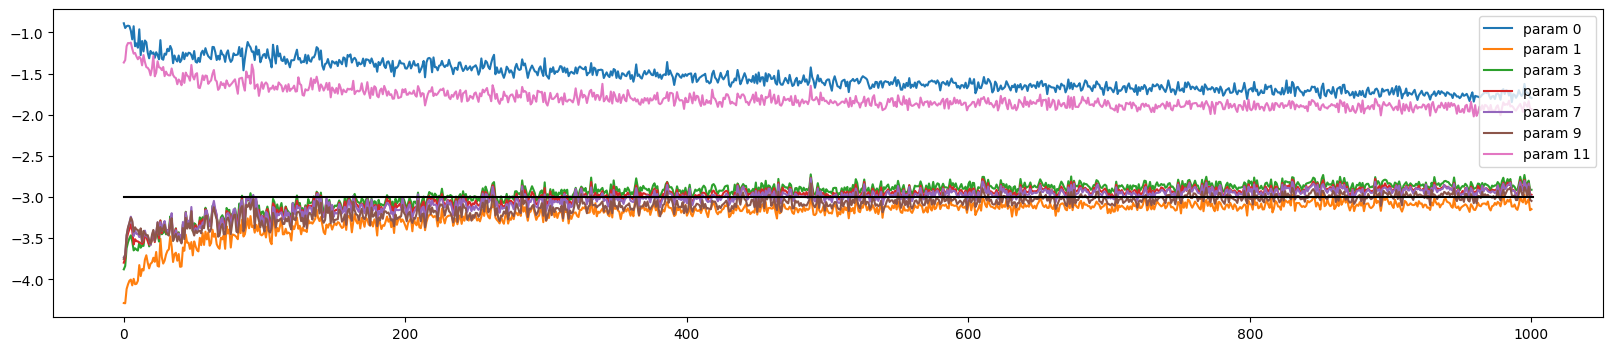

In [150]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### После полного обучения модели фиксирую метрики и качество семплинга

In [106]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9105384349822998
val 2.1011526584625244


In [107]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahela.
jhovi.
kemili.
tatyannah.
sky.
mahni.
farelynn.
kaeli.
nellara.
chaily.
kaleigh.
ham.
joce.
quintis.
lilea.
jadilyn.
jero.
dearistin.
jenni.
sabee.


### Добавляю BN

In [157]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) * 0.01
# BN тяжелый слой? греет ноут
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # Уменьшаем уверенность поледнего слоя
    layers[-1].gamma *= 0.1
    # Для всех остальных весов делаем балансировку (applying gain)
	# 1.	Инициализация весов с коэффициентом усиления
	# 2.	Масштабирование весов при инициализации
	# 3.	Корректировка масштаба весов (при инициализации)
	# 4.	Балансировка дисперсии весов

    # Без балансировки
    #     •	дисперсия активаций уменьшается слой за слоем
    #     •	градиенты затухают
    #     •	обучение медленное или нестабильное
    #
    # С балансировкой
    #     •	Var(activations) ≈ const
    #     •	Var(gradients) ≈ const
    #     •	сеть обучается быстрее и устойчивее
    #
    # Это идея Xavier / He initialization, но применённая вручную.

    for layer in layers:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

# Double list comprehansion
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47351


      0/  10000: 3.3017
   1000/  10000: 2.4094
   2000/  10000: 2.0727
   3000/  10000: 2.1737
   4000/  10000: 2.2298
   5000/  10000: 1.9088
   6000/  10000: 2.1354
   7000/  10000: 2.0337
   8000/  10000: 2.0908
   9000/  10000: 2.0974


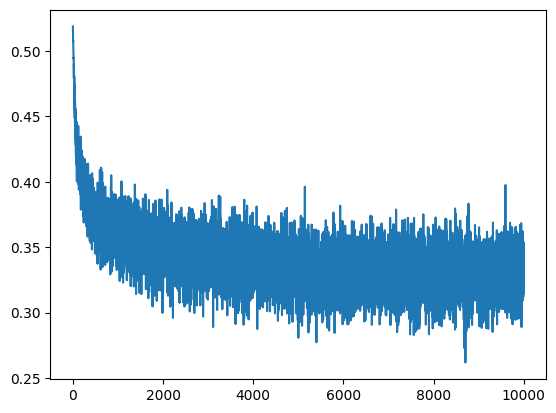

In [158]:
max_steps = 10_000
batch_size = 256
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Embedding
    emb = C[Xb] # embed characters into vectors
    # Оставь размерность 0, сделай вторую какой хочешь -> для каждого примера из 3 букв разверни их
    # в один уровень
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        # Вызывается метод __call__
        x = layer(x)

    # x — логиты (не softmax)
    # F.cross_entropy внутри применяет log_softmax и считает NLL loss
    loss = F.cross_entropy(x, Yb)
    # loss = F.nll_loss(F.log_softmax(x, dim=1), Yb)

    # Backward pass
    # for layer in layers:
    #     layer.out.retains_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update weights
    lr = 0.1 if i < 5000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i == 1000:
    #     break

plt.plot(lossi)

In [159]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.125580072402954
val 2.156397581100464


In [160]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khyimri.
reity.
skanden.
jazonte.
deliah.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
jora.
quinthanoul.
alianni.
watthonielryxix.
kael.
dura.
mel.
edi.


In [ ]:
# DONE; BONUS content below, not covered in video


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

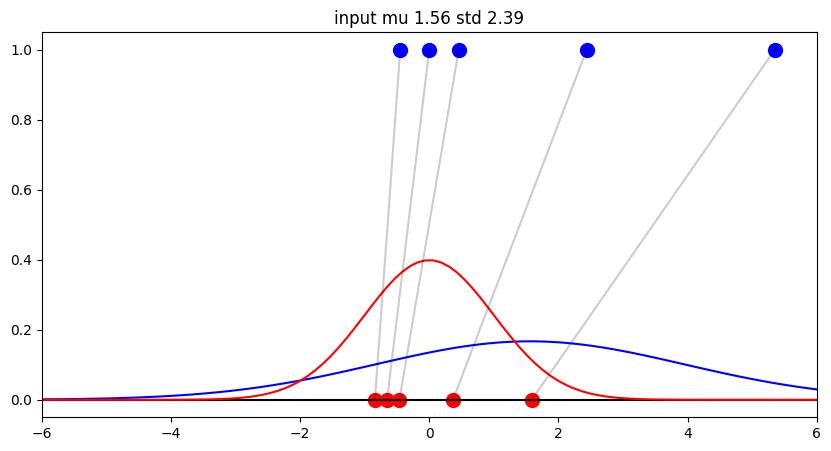

In [98]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

In [99]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [100]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953054189682007
